#### bootstrapping
OLS 방법으로는 계산한 가중치의 신뢰도를 알 수 없다. 이를 확인하기 위해 사용
- 회귀 분석에 사용한 데이터가 달라질 때, 분석 결과가 받는 영향을 알기 위한 방법
- 기존 데이터를 재표본화(resampling)함
    - 현실적으로 데이터의 수가 제한적이기 때문
    - resampling: 기존 N개의 데이터에서 다시 N개의 데이터를 선택(중복 가능)
    

In [1]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550485581797)

In [2]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()
result.params

const    -1.628364
X1       42.853356
dtype: float64

### bootstraping (n = 1000)

In [3]:
%%time
N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

CPU times: user 3.97 s, sys: 169 ms, total: 4.14 s
Wall time: 2.07 s


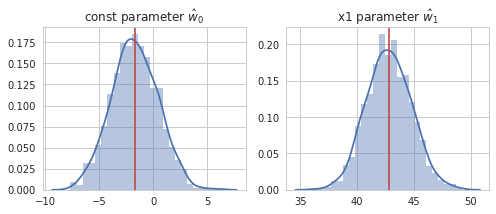

In [4]:
%matplotlib inline
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter $\hat{w}_0$")

ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter $\hat{w}_1$")
plt.show()

In [5]:
params_c.mean(), params_c.std()

(-1.7179283762165385, 2.1409810541015837)

In [6]:
params_x1.mean(), params_x1.std()

(42.805289081715962, 1.9757427036076487)

In [7]:
result.summary() # sdt err: 2.163

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        21:37:30   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.453      -5.920       2.663
X1            42.8534      2.142     20.008      0.000      38.603      47.104
==============================================================================
Omnibus:                        3.523   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.059
Skew:                          -0.073   Prob(JB):                        0.357
Kurtosis:                       2.312   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

# 확률론적 선형회귀모형
- boot straping 없이도 회귀분석 결과의 통계적 특성을 구할 수 있다.
- 데이터가 확률 변수로부터 생성된 표본이라고 가정

## 가정 1. 오차 분포에 대한 가정

### 1-1. 선형 정규 분포 가정

선형 회귀 분석의 기본 가정 : 종속 변수 y가 독립 변수 x의 선형 조합 $(w^Tx)$ 으로 결정되는 기댓값과 고정된 분산을 가지는 정규분포

$$ y \sim \mathcal{N}(w^Tx, \sigma^2)$$

y의 확률 밀도 함수(pdf)는 다음처럼 쓸 수 있다. 모수 벡터 $\theta=(w, \sigma^2)$

$$p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 )$$

- 다시 말해, $w^Tx, \sigma^2$에 따라 기댓값이 달라지는 $y$인 조건부확률이다.
- 확률 밀도 함수 자체가 $x$와 모수$\theta$ 에 의해 달라진다.


그런데, 이 관계식을 **오차(disturbance) $\epsilon_i$에 대해 표현하면** 식이 더 **간단**해진다.

$$\epsilon_i = y - w^Tx$$

오차의 확률밀도함수(pdf)는 다음과 같다.

$$p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 )$$

>주의: x, y 중 어느 것도 그 자체로 정규 분포일 필요는 없다.

### 1-2. 외생성(Exogeneity) 가정
(가정) 오차 $\epsilon$의 기댓값은 독립 변수 $x$에 상관없이 항상 0이라 가정한다.

$$\text{E}[\epsilon \mid x] = 0 $$

가정으로부터 오차의 무조건부 기댓값이 0임을 증명할 수 있다.

$$\text{E}[\text{E}[\epsilon \mid x]] = \text{E}[\epsilon]=0 $$

같은 가정으로부터 오차와 독립 변수 $x$가 무상관 관계라는 것도 증명.

$$\text{E}[\epsilon x] = 0 $$

- 다만, 곱의 평균이 0이지, 곱이 0은 아니다.
- 이를 통계적 직교라고 한다.

### 1-3. 조건부 독립 가정

(가정) $i$번째 샘플의 오차 $\epsilon_i$와 j번째 오차 $\epsilon_j$의 공분산 값이 $x$와 상관없이 항상 0이라고 가정한다.

$$\text{Cov}[\epsilon_i, \epsilon_j \mid x] = 0 \;\; (i,j=1,2,\ldots,N) $$

위 가정은 **각 샘플의 오차$\epsilon_i, \epsilon_j$가 서로 독립**이라는 가정과 같은 말이다.

이 가정과 위의 다른 가정들로부터 다음을 증명할 수 있다.

$$ \text{E}[\epsilon_i,\epsilon_j] = 0 $$

이를 공분산 행렬로 표현

$$ \text{Cov}[\epsilon] = \text{E}[\epsilon^{} \epsilon^T] = \sigma^2 I $$

## 가정 2. 독립 변수에 대한 가정

독립 변수의 공분산 행렬은 full rank이어야 한다.

즉, 독립 변수에서 서로 독립인 성분이 독립 변수의 갯수만큼 존재해야 한다.
만약 공분산 행렬이 full rank가 아니면, $X^TX$의 역행렬이 존재하지 않는다. 또한 공분산 행렬의 조건이 나쁜(ill-conditioned)경우에도 올바른 모수 추정이 되지 않는다.

# MLE 사용 선형회귀분석
- log likelihood -> 

$$\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 - \dfrac{N}{2} \log{2\pi}{\sigma^2}  \\
\end{eqnarray}$$

- 최적화 -> OLS와 같은 결과

$$\dfrac{\partial}{\partial w} \text{LL} = -C_1 \left( 2X^TX \hat{w} - 2X^Ty \right) = 0$$

$$\hat{w} = (X^TX)^{-1}X^T y$$
- 정규 방정식
$$X^T(X \hat{w} - y) = X^T(\hat{y} - y) = X^Te = 0$$ 

# 잔차의 분포
*(중요)*
확률론적 선형 회귀모형에 따르면 회귀분석에서 생기는 **잔차 $e = y - \hat{w}^Tx$ 도 정규 분포를 따른다.**

(증명)
확률론적 선형회귀모형의 오차 $\epsilon$과 잔차 $e$는 다음과 같은 관계를 가진다. 

$$\hat{y} = X\hat{w} =X (X^TX)^{-1}X^T y = Hy $$

행렬 H은 **Hat 행렬** 혹은 **projection matrix**, 또는 **influence matrix**라고 부르는 대칭 행렬이다. + 다음과 같은 성질이 있다.

$$HH = X (X^TX)^{-1}X^T X (X^TX)^{-1}X^T =H$$

Hat 행렬을 이용하여 잔차를 표현

$$ e = y - \hat{y} = y - Hy = (I - H)y $$

$M = I - H$ 라고 정의. 행렬 $M$은 **잔차(residual) 행렬**, **rejection matrix** 이라고 하며 마찬가지로 대칭 행렬이다. + H성질과 같은 성질이 있다.

$$ MM = M $$

이 식을 이용하여 다음과 같이 표현이 가능하다.

$$ e = My = M(Xw + \epsilon) = MXw + M\epsilon$$

그런데
$$ X^TM = X^T(1-H) = X^T - X^TH$$

$$= X^T \;\;- X^T X(X^TX)^{-1} \;\;X^T = X^T - X^T = 0$$
이고, 

$M$은 대칭이다.
$$ M^T X = MX = 0 $$

*벡터$M$과 벡터$X$가 직교한다고 볼 수 있다. (직교인 두 벡터의 내적은 0)*

이를 잔차식에 대입하면,

$$e = MXw + M\epsilon = M\epsilon $$

$$ e = M\epsilon $$

즉, **잔차 $e$는 오차 $\epsilon$의 선형 변환(linear transform)**이다.

정규 분포의 선형 변환은 마찬가지로 정규 분포 이므로 

**잔차도 정규 분포를 따른다.**

*오차가 정규분포인 이유 : central limit theorem*


또한, 오차의 기댓값이 $x$와 상관없이 0이므로 **잔차의 기댓값도 $x$와 상관없이 0 **이어야 한다.

### 만약, 잔차가 정규성을 따르지 않는다면?
- 전제가 틀렸다. 즉, 자연의 법칙이(오차가) 정규성을 따르지 않는다.
    - 다른 법칙을 찾아야함
    - 이를 파악하기 위해 다음과 같은 일을 함

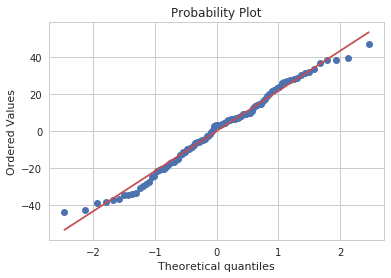

In [8]:
sp.stats.probplot(result.resid, plot=plt) ##qq
plt.show()

In [9]:
# 잔차 정규성 검정
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


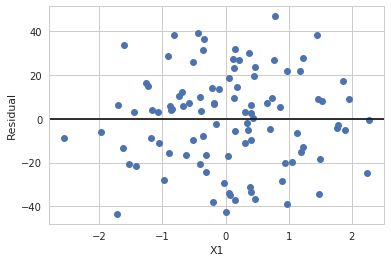

In [10]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

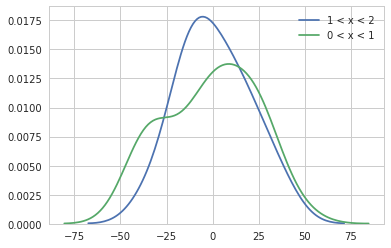

In [11]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

# 회귀 계수의 표준 오차
- 우리가 찾은 답($w$)의 신뢰도 체크, 오차가 있다면 얼마나 있는가

가중치 $\hat w$도 정규 분포 확률 변수인 $y$의 선형 변환이므로 정규 분포를 따른다.

$$\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\
&=& w + (X^TX)^{-1} X^T \epsilon \\
\end{eqnarray}$$

따라서 가중치 $\hat w$의 기댓값은 다음과 같다.
- 오차의 기댓값은 0, 나머지는 상수이기 때문에 $\text{E}[]$ 밖으로 나옴
- 왜 상수지? X는 확률이 아님(주어진 샘플), w는 자연의 법칙

$$\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w + (X^TX)^{-1} X^T \epsilon ] \\
&=&  w + (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\
&=& w
\end{eqnarray}$$

가중치의 (공)분산은 다음과 같다.

$$\begin{eqnarray}
\text{Cov}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}$$

$\sigma^2$의 값은 알지 못하므로 다음과 같이 추정한다.

$$s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$

여기에서 N은 표본 데이터의 수(rows), K는 모수의 갯수(columns)이다. bias (y절편)을 고려한다면 K는 차원의 수 D에 1을 더한 값이 된다.

$$ K = D + 1 $$

따라서 $\hat w$의 (공)분산 추정값은 다음과 같다.

$$ \text{Est.Cov}[\hat{w}]  = s^2(X^TX)^{-1} $$

이 공분산 행렬에서 우리가 관심을 가지는 값은 $w_i$의 분산을 뜻하는 대각 성분이다.

$$\text{Est.Var}[\hat{w}_i]  = \left( \text{Est.Cov}[\hat{w}] \right)_{ii} \;\; (i=0, \ldots, K-1)$$

이 값에서 구한 표준 편차를 **회귀 계수의 표준 오차(Standard Error of Regression Coefficient)**라고 한다.

$${se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} \;\; (i=0, \ldots, K-1) $$

실제 가중치$w$(정답) 와 우리가 추정한 가중치 $\hat w$(나의 답)의 차이, 즉
**모수 오차는 기댓값이 0이고 표준 오차($se_i)$를 분산으로 가지는 스튜던트-t분포를** 따른다.

$$\dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} \;\; (i=0, \ldots, K-1) $$

In [12]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           2.21e-36
Time:                        21:37:30   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.453      -5.920       2.663
X1            42.8534      2.142     20.008      0.000      38.603      47.104
==============================================================================
Omnibus:                        3.523   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                2.059
Skew:                          -0.073   Prob(JB):                        0.357
Kurtosis:                       2.312   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


### Loss-of-Fit 회귀분석 F-검정
모형의 성능을 비교할 수 있다. 유의확률이 작으면 작을수록 좋다.

Log-Likelihood값은 클수록 좋다(최적화, 최댓값)